In [ ]:
import os
import sys

# adding preprocessing directory to path
current_dir = os.path.dirname(os.path.abspath("preprocessing"))
parent_dir = os.path.join(current_dir, '..')
sys.path.append(parent_dir)

from preprocessing.common import midi_dataframe, midi_to_tensor

import seaborn as sns
sns.set_theme()

2025-07-30 22:51:05.376913: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
test_file = r"../data/midi/Beethoven/Symphony op125 n9 2mov ''Choral''.mid"

events_df = midi_dataframe(test_file)
test_tensor = midi_to_tensor(events_df)
test_tensor.shape

TensorShape([14, 127, 211389])

<Axes: >

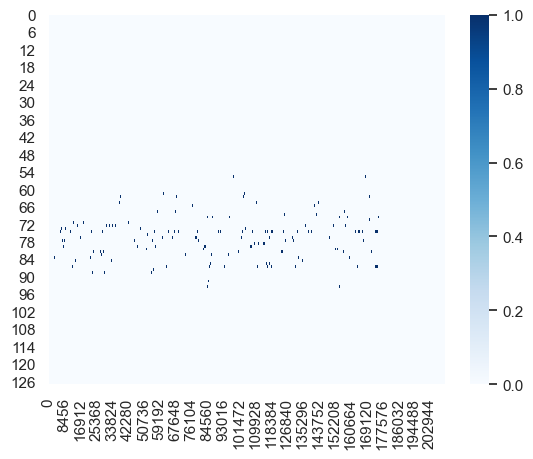

In [3]:
sns.heatmap(test_tensor[0], cmap="Blues")